# Features & Classifier Selection

This notebook presents an in-depth exploration of **Feature and Classifier Selection** techniques, focusing on optimizing classification performance through a structured approach to feature evaluation and model comparison.

The methodology for selecting the best features and classifiers involves the following steps:

1. **Feature Selection Techniques**: Various methods for feature selection are applied, including filter-based, wrapper-based, and embedded approaches. Each technique is evaluated based on its ability to improve classification accuracy while reducing model complexity.
2. **Dimensionality Reduction**: Techniques such as Principal Component Analysis (PCA) and Linear Discriminant Analysis (LDA) are employed to reduce the feature space, ensuring the classifier's efficiency and avoiding overfitting.
3. **Classifier Comparison**: A range of classifiers, including decision trees, random forests, support vector machines (SVM), and neural networks, are evaluated using cross-validation to identify the model that performs best for the selected feature set.
4. **Hyperparameter Tuning**: For each classifier, hyperparameters are optimized using grid search or randomized search techniques to ensure the best possible model performance.
5. **Model Evaluation**: Classifiers are compared based on several performance metrics, such as accuracy, ROC-AUC, precision, recall, and F1-score. These metrics guide the final selection of both features and classifiers.
6. **Pipeline Integration**: The selected features and classifiers are integrated into a streamlined pipeline that automates the feature selection and classification process, making it easier to apply to new datasets.

This comprehensive approach aims to enhance the overall classification performance by carefully balancing feature relevance and classifier robustness, ensuring the chosen model generalizes well to unseen data. The results are compared with baseline methods to demonstrate the improvements achieved in terms of predictive accuracy and model efficiency.


# Settings

## Packages Loading

In [1]:
# PACKAGES
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import matplotlib.pyplot as plt
import warnings
import numpy as np
import seaborn as sns
from scipy import stats
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score, mutual_info_score
from sklearn.feature_selection import mutual_info_classif
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader

## Parameters

In [2]:
# PARAMETERS
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = -1 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples
noise_std_filter = 0.01  # Example noise standard deviation to filter
max_neighborhood_size_filter = 2  # Example filter for neighborhood size

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [7]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/data/to_use/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20] # 
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)

# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]:  # 
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/data/to_use/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/data/to_use/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/data/to_use/'))

P18_N5_Nj2_n0.01 done
P20_N5_Nj2_n0.01 done
P16_N5_Nj2_n0.01 done
P14_N5_Nj2_n0.01 done
P10_N5_Nj2_n0.01 done
P15_N5_Nj2_n0.01 done
P11_N5_Nj2_n0.01 done
P19_N5_Nj2_n0.01 done
P13_N5_Nj2_n0.01 done
P3_N5_Nj2_n0.01 done
P4_N5_Nj2_n0.01 done
P12_N5_Nj2_n0.01 done
P9_N5_Nj2_n0.01 done
P6_N5_Nj2_n0.01 done
P8_N5_Nj2_n0.01 done
P2_N5_Nj2_n0.01 done
P7_N5_Nj2_n0.01 done
P1_N5_Nj2_n0.01 done


18

# Decriptors Generation

In [8]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/descr/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables, maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

100%|██████████| 18/18 [03:36<00:00, 12.01s/it]


# Features Selection

## Prepare descriptors

### Packages & Setup

In [6]:
import warnings
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.exceptions import UndefinedMetricWarning
from scipy import stats
from collections import Counter

# Define constants
# SEED = 42
# N_JOBS = -1

# Suppress specified warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings("ignore", category=stats.ConstantInputWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Load

In [3]:
# Load descriptors
descriptor_path = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/descr/'
descriptors = []
for file in sorted(os.listdir(descriptor_path)):
    descriptors.append(pd.read_pickle(descriptor_path+file)) 

# Concatenate descriptors
descriptors_df = pd.concat(descriptors, ignore_index=True)

descriptorsss = descriptors_df

### Data Cleaning

In [75]:
coordinate_cols = ['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest', 'is_causal']
coordinates = descriptorsss[coordinate_cols]
descriptors_m = descriptorsss.drop(columns=coordinate_cols)
print(f'The dataset has {descriptors_m.shape[1]} descriptors and {coordinates.shape[1]} coordinates')

# Data cleaning steps

# Remove columns with constant values
descriptors = descriptors_m.loc[:, (descriptors_m != descriptors_m.iloc[0]).any()]

# Remove columns with NaN values
descriptors = descriptors.dropna(axis=1, how='all')

# Replace infinite values with NaN and then drop NaN
descriptors = descriptors.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

# Optionally, impute missing values instead of dropping columns
# descriptors.fillna(descriptors.mean(), inplace=True)

# Remove columns with zero variance
descriptors = descriptors.loc[:, descriptors.var() != 0]

# Show removed columns
removed_columns = set(descriptors_m.columns) - set(descriptors.columns)
print(f'We remove columns: {removed_columns}')

# Head
descriptors.head()

# Columns in the dataset
print(f'The dataset has now {descriptors.shape[1]} descriptors')


The dataset has 48 descriptors and 8 coordinates
We remove columns: {'n_features/n_samples', 'n_features', 'mbe_mbe_eff_q0', 'mbe_mbe_eff_q2', 'n_samples', 'mbe_mbe_eff_q1'}
The dataset has now 42 descriptors


### Strategies

In [7]:
# Columns in the dataset
print(f'The dataset has {descriptors.shape[1]} descriptors')

# Normalize data
descriptors = pd.DataFrame(StandardScaler().fit_transform(descriptors), columns=descriptors.columns)

def correlation_filter(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > abs(threshold))]
    return df.drop(columns=to_drop)

def correlation_target_filter(df, threshold=0.5, coordinates=None):
    target = coordinates['is_causal']
    corr_matrix = df.corrwith(target).abs()
    to_drop = corr_matrix[corr_matrix < abs(threshold)].index
    return df.drop(columns=to_drop)

def pca_filter(df, threshold=0.95):
    # Normalize data
    df = pd.DataFrame(StandardScaler().fit_transform(df))
    pca = PCA(n_components=threshold, random_state=SEED)
    principalComponents = pca.fit_transform(df)
    principalDf = pd.DataFrame(data=principalComponents, 
                               columns=[f'PC{i+1}' for i in range(principalComponents.shape[1])],
                               index=df.index)
    return principalDf


def random_forest_filter(df, coordinates=None, threshold=0.01):
    target = coordinates['is_causal']
    clf = RandomForestClassifier(n_estimators=100, random_state=SEED, n_jobs=N_JOBS)
    clf.fit(df, target)
    feature_importances = clf.feature_importances_
    feature_importances_series = pd.Series(feature_importances, index=df.columns)
    to_drop = feature_importances_series[feature_importances_series < threshold].index
    return df.drop(columns=to_drop)

def information_gain_filter(df, coordinates=None, threshold=0.1):
    target = coordinates['is_causal']
    ig = df.apply(lambda x: mutual_info_score(x, target))
    to_drop = ig[ig < threshold].index
    return df.drop(columns=to_drop)


# Correlation Filter
descriptors_filtered_corr = correlation_filter(descriptors)
print(f'After correlation filter, the number of descriptors is {descriptors_filtered_corr.shape[1]}')

# Correlation with Target Filter
descriptors_filtered_targ_corr = correlation_target_filter(descriptors, threshold=0.2, coordinates=coordinates)
print(f'After correlation target filter, the number of descriptors is {descriptors_filtered_targ_corr.shape[1]}')

# Random Forest Feature Importance Filter
descriptors_filtered_rf = random_forest_filter(descriptors, coordinates=coordinates, threshold=0.01)
print(f'After random forest filter, the number of descriptors is {descriptors_filtered_rf.shape[1]}')

# Information Gain Filter
descriptors_filtered_info = information_gain_filter(descriptors, coordinates=coordinates, threshold=0.1)
print(f'After information gain filter, the number of descriptors is {descriptors_filtered_info.shape[1]}')

# PCA filter separately if needed
descriptors_filtered_pca = pca_filter(descriptors, threshold=0.95)
print(f'After PCA filter, the number of principal components is {descriptors_filtered_pca.shape[1]}')


The dataset has 42 descriptors
After correlation filter, the number of descriptors is 25
After correlation target filter, the number of descriptors is 15
After random forest filter, the number of descriptors is 37
After information gain filter, the number of descriptors is 34
After PCA filter, the number of principal components is 15


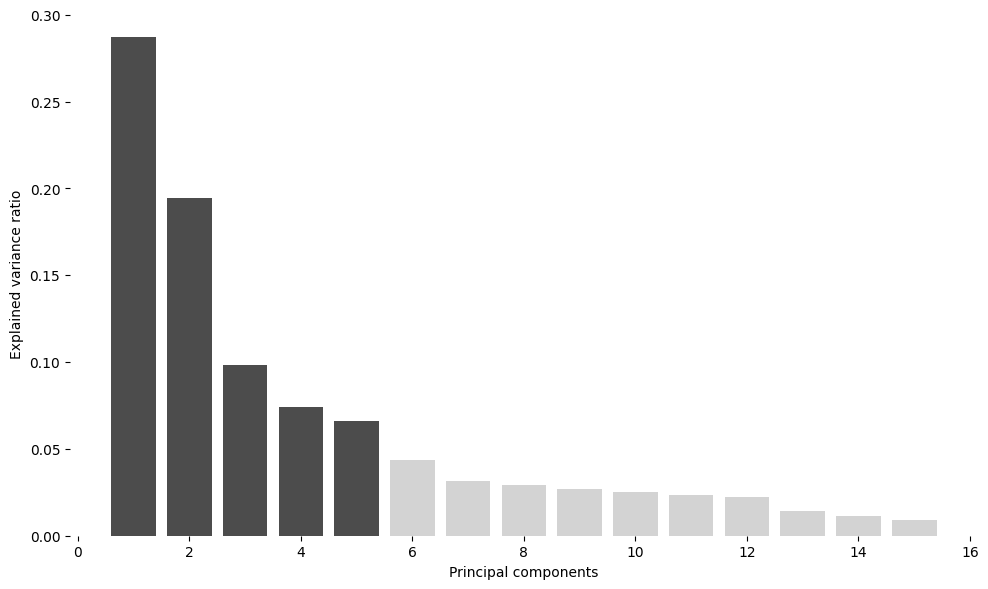

the first 5 components explain 72.1% of the variance


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming descriptors is your dataset (e.g., a pandas DataFrame or a NumPy array)
# If descriptors is not standardized, it's important to standardize it before PCA
# Standardizing the dataset
scaler = StandardScaler()
descriptors_scaled = scaler.fit_transform(descriptors)

# Fit PCA
pca = PCA()
pca.fit(descriptors_scaled)

# Explained variance
explained_variance = pca.explained_variance_ratio_[:15]

# Scree plot
plt.figure(figsize=(10, 6))

# Plot the first five bars in black
plt.bar(range(1, 6), explained_variance[:5], alpha=0.7, align='center', label='First five components', color='black')

# Plot the remaining bars in dark grey
plt.bar(range(6, len(explained_variance) + 1), explained_variance[5:], alpha=0.5, align='center', label='Remaining components', color='darkgrey')

# Cumulative explained variance (optional, you can uncomment this if needed)
# plt.step(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), where='mid', label='Cumulative explained variance')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
# plt.legend(loc='best')  # Uncomment if you want a legend
# plt.title('Scree Plot & Cumulative Explained Variance')  # Uncomment if you want a title

# Remove borders
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.tight_layout()
plt.show()


# # Optional: Print the explained variance for each component
# for i, ev in enumerate(explained_variance, 1):
#     print(f'PC{i}: {ev:.4f}')

print(f'the first 5 components explain {round(sum(explained_variance[:5])*100,1)}% of the variance')

# # scatterplot of the first four principal components
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(descriptors_scaled)
# principalDf = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# # Concatenate with target
# principalDf = pd.concat([principalDf, coordinates['is_causal']], axis=1)

# # Scatterplot
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=principalDf, x='PC1', y='PC2', hue='is_causal', palette='viridis')
# plt.title('Scatterplot of the first two principal components')
# plt.tight_layout()
# plt.show()



### Kind of Selections

In [9]:
# Reload original descriptors for variable selection
print(f'Descriptors file has {descriptorsss.shape[1]} variables')


# Prepare sets for variable selection (excluding PCA components)
filter_columns = [
    set(descriptors_filtered_corr.columns),
    set(descriptors_filtered_targ_corr.columns),
    # set(descriptors_filtered_mi.columns),
    set(descriptors_filtered_rf.columns),
    set(descriptors_filtered_info.columns),
    # set(descriptors_filtered_pca.columns)
]

# names of filter_columns
filter_names = str('Correlation, Random Forest, Information Gain and Target Corr') # , PCA, Mutual Information
print(f'We used {filter_names}, filters')

# Define coordinate variables to exclude
coordinate_vars = set(coordinate_cols)

# Remove coordinate variables from each filter set
filter_columns = [cols - coordinate_vars for cols in filter_columns]

# **Common Variables Across All Filters**
common_vars = set.intersection(*filter_columns)
# print(f'Number of common descriptors across all filters: {len(common_vars)}')

# Concatenate with coordinates
descriptors_filtered_common = descriptors[list(common_vars)].copy()
descriptors_filtered_common = pd.concat([coordinates.reset_index(drop=True), descriptors_filtered_common.reset_index(drop=True)], axis=1)
print(f'After common filter, the number of descriptors is {descriptors_filtered_common.shape[1]}')

# **Union of Variables Present in Any Filter**
union_vars = set.union(*filter_columns)
# print(f'Number of descriptors in the union of all filters: {len(union_vars)}')

# Subset descriptors and concatenate with coordinates
descriptors_filtered_at_least_one = descriptors[list(union_vars)].copy()
descriptors_filtered_at_least_one = pd.concat([coordinates.reset_index(drop=True), descriptors_filtered_at_least_one.reset_index(drop=True)], axis=1)
print(f'After union filter, the number of descriptors is {descriptors_filtered_at_least_one.shape[1]}')

# **Variables Present in at Least Three Filters**
# Count occurrences of each variable across filters
counter = Counter()
for cols in filter_columns:
    counter.update(cols)

# Select variables present in at least three filters
common_3_vars = {var for var, count in counter.items() if count >= 3}
# print(f'Number of descriptors present in at least three filters: {len(common_3_vars)}')

# Subset descriptors and concatenate with coordinates
descriptors_filtered_at_least_three = descriptors[list(common_3_vars)].copy()
descriptors_filtered_at_least_three = pd.concat([coordinates.reset_index(drop=True), descriptors_filtered_at_least_three.reset_index(drop=True)], axis=1)
print(f'After at least three filter, the number of descriptors is {descriptors_filtered_at_least_three.shape[1]}')



Descriptors file has 56 variables
We used Correlation, Random Forest, Information Gain and Target Corr, filters
After common filter, the number of descriptors is 13
After union filter, the number of descriptors is 48
After at least three filter, the number of descriptors is 35


### Save filtered descriptors

In [11]:
# Save filtered descriptors
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/'
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/descr/'

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

descriptors_to_filter = {}
for file in sorted(os.listdir(input_folder)):
    descriptors_to_filter[file] = pd.read_pickle(input_folder+file)

# columns names in common filter
common_vars = list(common_vars)
# columns names in at least one filter
union_vars = list(union_vars)
# columns names in at least three filters
common_3_vars = list(common_3_vars)
# worse descriptors
no_worse_vars = list(set(descriptorsss.columns) - set(removed_columns))
# best descriptors
no_best_vars = list(set(descriptorsss.columns) - set(common_vars))

# add coordinates to the filter methods list
common_vars = coordinate_cols + common_vars
union_vars = coordinate_cols + union_vars
common_3_vars = coordinate_cols + common_3_vars

# filter methods list
filter_methods = ['Common', 'AtLeastOne', 'AtLeastThree', 'NoBest', 'NoWorse']

# folder to save filtered descriptors
output_common = output_folder + 'Common/'
output_at_least_one = output_folder + 'AtLeastOne/'
output_at_least_three = output_folder + 'AtLeastThree/'
output_no_best = output_folder + 'NoBest/'
output_no_worse = output_folder + 'NoWorse/'

# create output folder if it does not exist
if not os.path.exists(output_common):
    os.makedirs(output_common)
if not os.path.exists(output_at_least_one):
    os.makedirs(output_at_least_one)
if not os.path.exists(output_at_least_three):
    os.makedirs(output_at_least_three)
if not os.path.exists(output_no_best):
    os.makedirs(output_no_best)
if not os.path.exists(output_no_worse):
    os.makedirs(output_no_worse)


# filter and save
for file in tqdm(descriptors_to_filter.keys()):
    # filter descriptors
    descriptors_filtered_common = descriptors_to_filter[file][common_vars].copy()
    descriptors_filtered_at_least_one = descriptors_to_filter[file][union_vars].copy()
    descriptors_filtered_at_least_three = descriptors_to_filter[file][common_3_vars].copy()
    decriptors_filtered_no_best = descriptors_to_filter[file][no_best_vars].copy()
    decriptors_filtered_no_worse = descriptors_to_filter[file][no_worse_vars].copy()

    # save filtered descriptors
    descriptors_filtered_common.to_pickle(output_common+file)
    descriptors_filtered_at_least_one.to_pickle(output_at_least_one+file)
    descriptors_filtered_at_least_three.to_pickle(output_at_least_three+file)
    decriptors_filtered_no_best.to_pickle(output_no_best+file)
    decriptors_filtered_no_worse.to_pickle(output_no_worse+file)


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:00<00:00, 46.27it/s]


### Checks for errors

In [10]:
# load the filtered descriptors
descriptors_filtered_corr = pd.read_pickle(output_folder+f'Corr.pkl')
descriptors_filtered_targ_corr = pd.read_pickle(output_folder+f'TargCorr.pkl')
descriptors_filtered_mi = pd.read_pickle(output_folder+f'MI.pkl')
descriptors_filtered_rf = pd.read_pickle(output_folder+f'RF.pkl')
descriptors_filtered_info = pd.read_pickle(output_folder+f'Info.pkl')
descriptors_filtered_pca = pd.read_pickle(output_folder+f'PCA.pkl')
descriptors_filtered_common = pd.read_pickle(output_folder+f'Common.pkl')
descriptors_filtered_at_least_one = pd.read_pickle(output_folder+f'AtLeastOne.pkl')
descriptors_filtered_at_least_three = pd.read_pickle(output_folder+f'AtLeastThree.pkl')


# Check for missing values
print(f'Correlation Filter: {descriptors_filtered_corr.isnull().sum().sum()} missing values')
print(f'Correlation Target Filter: {descriptors_filtered_targ_corr.isnull().sum().sum()} missing values')
print(f'Mutual Information Filter: {descriptors_filtered_mi.isnull().sum().sum()} missing values')
print(f'Random Forest Filter: {descriptors_filtered_rf.isnull().sum().sum()} missing values')
print(f'Information Gain Filter: {descriptors_filtered_info.isnull().sum().sum()} missing values')
# print(f'PCA Filter: {descriptors_filtered_pca.isnull().sum().sum()} missing values')
print(f'Common Filter: {descriptors_filtered_common.isnull().sum().sum()} missing values')
print(f'At Least One Filter: {descriptors_filtered_at_least_one.isnull().sum().sum()} missing values')
print(f'At Least Three Filter: {descriptors_filtered_at_least_three.isnull().sum().sum()} missing values')

# Check for infinite values
print(f'Correlation Filter: {np.isinf(descriptors_filtered_corr).sum().sum()} infinite values')
print(f'Correlation Target Filter: {np.isinf(descriptors_filtered_targ_corr).sum().sum()} infinite values')
print(f'Mutual Information Filter: {np.isinf(descriptors_filtered_mi).sum().sum()} infinite values')
print(f'Random Forest Filter: {np.isinf(descriptors_filtered_rf).sum().sum()} infinite values')
print(f'Information Gain Filter: {np.isinf(descriptors_filtered_info).sum().sum()} infinite values')
# print(f'PCA Filter: {np.isinf(descriptors_filtered_pca).sum().sum()} infinite values')
print(f'Common Filter: {np.isinf(descriptors_filtered_common).sum().sum()} infinite values')
print(f'At Least One Filter: {np.isinf(descriptors_filtered_at_least_one).sum().sum()} infinite values')
print(f'At Least Three Filter: {np.isinf(descriptors_filtered_at_least_three).sum().sum()} infinite values')

# Check for NaN values
print(f'Correlation Filter: {np.isnan(descriptors_filtered_corr).sum().sum()} NaN values')
print(f'Correlation Target Filter: {np.isnan(descriptors_filtered_targ_corr).sum().sum()} NaN values')
print(f'Mutual Information Filter: {np.isnan(descriptors_filtered_mi).sum().sum()} NaN values')
print(f'Random Forest Filter: {np.isnan(descriptors_filtered_rf).sum().sum()} NaN values')
print(f'Information Gain Filter: {np.isnan(descriptors_filtered_info).sum().sum()} NaN values')
# print(f'PCA Filter: {np.isnan(descriptors_filtered_pca).sum().sum()} NaN values')
print(f'Common Filter: {np.isnan(descriptors_filtered_common).sum().sum()} NaN values')
print(f'At Least One Filter: {np.isnan(descriptors_filtered_at_least_one).sum().sum()} NaN values')
print(f'At Least Three Filter: {np.isnan(descriptors_filtered_at_least_three).sum().sum()} NaN values')

# Check for duplicated rows
print(f'Correlation Filter: {descriptors_filtered_corr.duplicated().sum()} duplicated rows')
print(f'Correlation Target Filter: {descriptors_filtered_targ_corr.duplicated().sum()} duplicated rows')
print(f'Mutual Information Filter: {descriptors_filtered_mi.duplicated().sum()} duplicated rows')
print(f'Random Forest Filter: {descriptors_filtered_rf.duplicated().sum()} duplicated rows')
print(f'Information Gain Filter: {descriptors_filtered_info.duplicated().sum()} duplicated rows')
# print(f'PCA Filter: {descriptors_filtered_pca.duplicated().sum()} duplicated rows')
print(f'Common Filter: {descriptors_filtered_common.duplicated().sum()} duplicated rows')
print(f'At Least One Filter: {descriptors_filtered_at_least_one.duplicated().sum()} duplicated rows')
print(f'At Least Three Filter: {descriptors_filtered_at_least_three.duplicated().sum()} duplicated rows')

# Check for duplicated columns
print(f'Correlation Filter: {descriptors_filtered_corr.columns.duplicated().sum()} duplicated columns')
print(f'Correlation Target Filter: {descriptors_filtered_targ_corr.columns.duplicated().sum()} duplicated columns')
print(f'Mutual Information Filter: {descriptors_filtered_mi.columns.duplicated().sum()} duplicated columns')
print(f'Random Forest Filter: {descriptors_filtered_rf.columns.duplicated().sum()} duplicated columns')
print(f'Information Gain Filter: {descriptors_filtered_info.columns.duplicated().sum()} duplicated columns')
# print(f'PCA Filter: {descriptors_filtered_pca.columns.duplicated().sum()} duplicated columns')
print(f'Common Filter: {descriptors_filtered_common.columns.duplicated().sum()} duplicated columns')
print(f'At Least One Filter: {descriptors_filtered_at_least_one.columns.duplicated().sum()} duplicated columns')
print(f'At Least Three Filter: {descriptors_filtered_at_least_three.columns.duplicated().sum()} duplicated columns')

# Check for constant columns
print(f'Correlation Filter: {descriptors_filtered_corr.columns[descriptors_filtered_corr.nunique() == 1]} constant columns')
print(f'Correlation Target Filter: {descriptors_filtered_targ_corr.columns[descriptors_filtered_targ_corr.nunique() == 1]} constant columns')
print(f'Mutual Information Filter: {descriptors_filtered_mi.columns[descriptors_filtered_mi.nunique() == 1]} constant columns')
print(f'Random Forest Filter: {descriptors_filtered_rf.columns[descriptors_filtered_rf.nunique() == 1]} constant columns')
print(f'Information Gain Filter: {descriptors_filtered_info.columns[descriptors_filtered_info.nunique() == 1]} constant columns')
# print(f'PCA Filter: {descriptors_filtered_pca.columns[descriptors_filtered_pca.nunique() == 1]} constant columns')
print(f'Common Filter: {descriptors_filtered_common.columns[descriptors_filtered_common.nunique() == 1]} constant columns')
print(f'At Least One Filter: {descriptors_filtered_at_least_one.columns[descriptors_filtered_at_least_one.nunique() == 1]} constant columns')
print(f'At Least Three Filter: {descriptors_filtered_at_least_three.columns[descriptors_filtered_at_least_three.nunique() == 1]} constant columns')


FileNotFoundError: [Errno 2] No such file or directory: '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/Corr.pkl'

### Plots

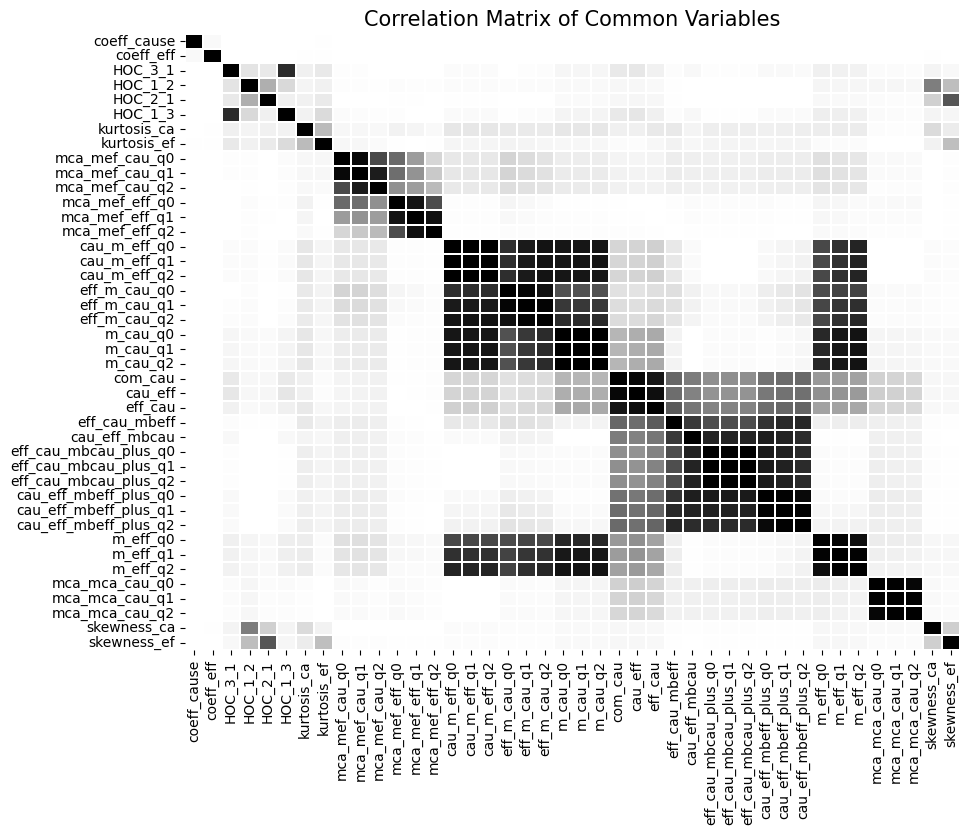

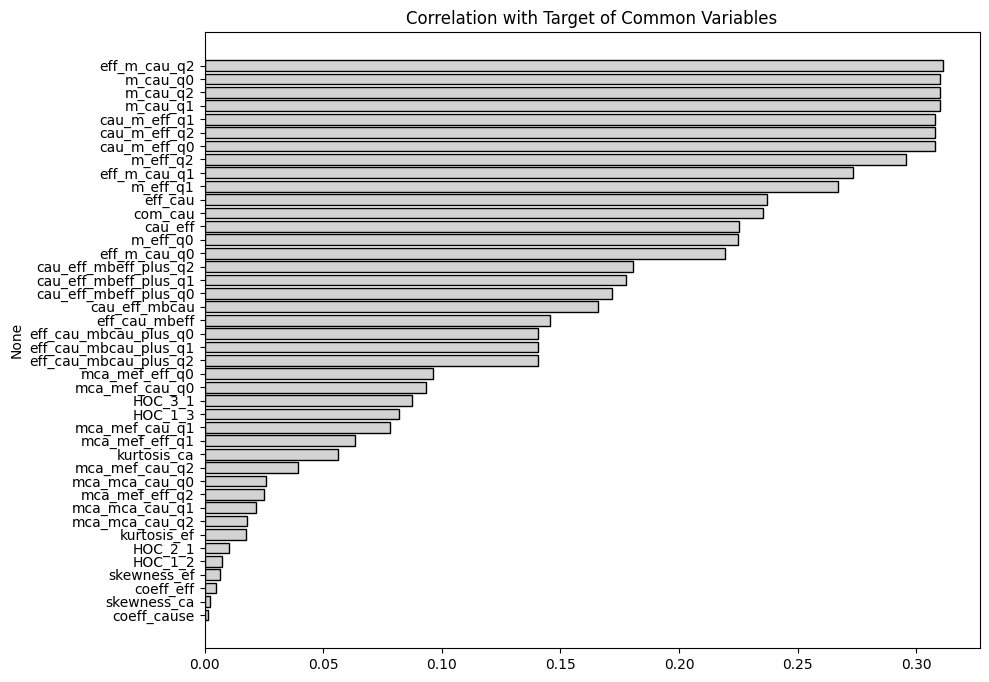

In [58]:
# plot the absolute value correlation matrix
def plot_correlation_matrix(df, title='Correlation Matrix', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    # set color to grey scale and put borders 
    sns.heatmap(df.corr().abs(), cmap='Greys', annot=False, fmt='.2f', cbar=False, linewidths=0.1)
    plt.title(title, fontsize=15)
    plt.show()

# Plot correlation matrix
plot_correlation_matrix(descriptors, title='Correlation Matrix of Common Variables')


# plot correlation with target
def plot_correlation_target(df, target, title='Correlation with Target', figsize=(10, 8)):
    plt.figure(figsize=figsize)
    corr = df.corrwith(target).abs().sort_values(ascending=False)
    sns.barplot(x=corr.values, y=corr.index)
    # set color to white and black
    plt.gca().spines['bottom'].set_color('black')
    # set color of bars to black
    plt.barh(corr.index, corr.values, color='lightgrey', edgecolor='black')

    plt.title(title)
    plt.show()

# Plot correlation with target
plot_correlation_target(descriptors, coordinates['is_causal'], title='Correlation with Target of Common Variables')

## Classification

#### Prepare data

In [12]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results


#### Prepare descriptors

In [13]:
# we create a dictionary to store the results
descriptors_training = {}
descriptors_training_atleastone = {}
descriptors_training_atleastthree = {}
descriptors_training_common = {}
descriptors_training_no_best = {}
descriptors_training_no_worse = {}
descriptors_root_atleastthree = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/AtLeastThree/'
descriptors_root_common = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/Common/'
descriptors_root_atleastone = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/AtLeastOne/'
descriptors_root_no_best = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/NoBest/'
descriptors_root_no_worse = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/NoWorse/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root_atleastthree)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root_atleastthree, testing_file))
        descriptors_training_atleastthree[testing_file] = df

for testing_file in sorted(os.listdir(descriptors_root_common)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root_common, testing_file))
        descriptors_training_common[testing_file] = df

for testing_file in sorted(os.listdir(descriptors_root_atleastone)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root_atleastone, testing_file))
        descriptors_training_atleastone[testing_file] = df

for testing_file in sorted(os.listdir(descriptors_root_no_best)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root_no_best, testing_file))
        descriptors_training_no_best[testing_file] = df
    
for testing_file in sorted(os.listdir(descriptors_root_no_worse)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root_no_worse, testing_file))
        descriptors_training_no_worse[testing_file] = df

In [36]:
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/Common/'
# descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/AtLeastOne/'
# descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/AtLeastThree/'
# descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/descr/'
# descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/NoBest/'
# descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/descriptors/Regression/TD2C/filtered/NoWorse/'


# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [37]:
for n_vars, todo in todos.items():
    d2c_rocs_process = {}
    d2c_precision_process = {}
    d2c_recall_process = {}
    d2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_rocs_process[gen_process_number] = rocs
        d2c_precision_process[gen_process_number] = precisions
        d2c_recall_process[gen_process_number] = recalls
        d2c_f1_process[gen_process_number] = f1s

100%|██████████| 18/18 [02:27<00:00,  8.18s/it]


#### Save Results

In [38]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_alo.pkl'), 'wb') as f:
    everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_c.pkl'), 'wb') as f:
#     everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_alt.pkl'), 'wb') as f:
#     everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_original.pkl'), 'wb') as f:
#     everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_nb.pkl'), 'wb') as f:
#     everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_nw.pkl'), 'wb') as f:
#     everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
#     pickle.dump(everything, f)


#### Load data

In [39]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/Computational_cost_reduction/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_c'), 'rb') as f:
        TD2C_roc_Common, TD2C_precision_Common, TD2C_recall_Common, TD2C_f1_Common = pickle.load(f)

with open(os.path.join(input_folder, 'journal_alo'), 'rb') as f:
        TD2C_roc_AtLeastOne, TD2C_precision_AtLeastOne, TD2C_recall_AtLeastOne, TD2C_f1_AtLeastOne = pickle.load(f)

with open(os.path.join(input_folder, 'journal_alt'), 'rb') as f:
        TD2C_roc_AtLeastThree, TD2C_precision_AtLeastThree, TD2C_recall_AtLeastThree, TD2C_f1_AtLeastThree = pickle.load(f)

with open(os.path.join(input_folder, 'journal_original.pkl'), 'rb') as f:
        TD2C_roc_original, TD2C_precision_original, TD2C_recall_original, TD2C_f1_original = pickle.load(f)

with open(os.path.join(input_folder, 'journal_nb.pkl'), 'rb') as f:
        TD2C_roc_nb, TD2C_precision_nb, TD2C_recall_nb, TD2C_f1_nb = pickle.load(f)

with open(os.path.join(input_folder, 'journal_nw.pkl'), 'rb') as f:
        TD2C_roc_nw, TD2C_precision_nw, TD2C_recall_nw, TD2C_f1_nw = pickle.load(f)



#### Plot

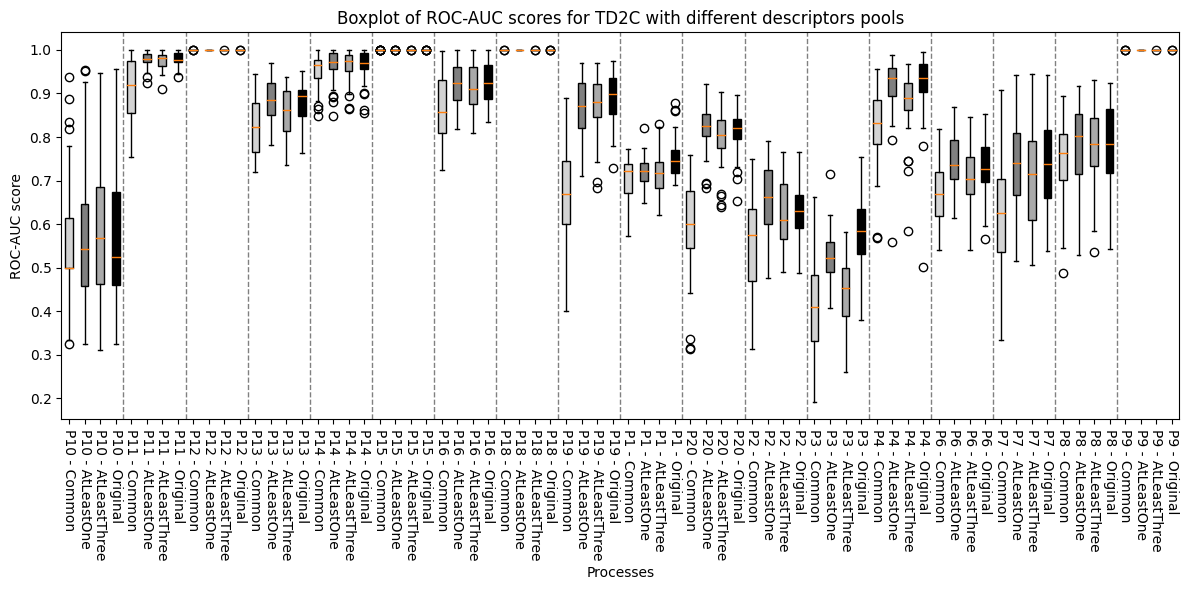

In [64]:
##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_roc_Common)
df2 = pd.DataFrame(TD2C_roc_AtLeastOne)
df3 = pd.DataFrame(TD2C_roc_AtLeastThree)
df4 = pd.DataFrame(TD2C_roc_original)
# df5 = pd.DataFrame(TD2C_roc_nb)
# df6 = pd.DataFrame(TD2C_roc_nw)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col].values)
    combined_data.append(df2[col].values)
    combined_data.append(df3[col].values)
    combined_data.append(df4[col].values)
    # combined_data.append(df5[col].values)
    # combined_data.append(df6[col].values)

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'P{col} - Common')
    labels.append(f'P{col} - AtLeastOne')
    labels.append(f'P{col} - AtLeastThree')
    labels.append(f'P{col} - Original')
    # labels.append(f'P{col} - NoBest')
    # labels.append(f'P{col} - NoWorse')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightgrey', 'grey', 'darkgrey', 'black']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 4])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C with different descriptors pools')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
# add a vertical line avery 4 observations
for i in range(4, len(labels), 4):
    plt.axvline(i+0.5, color='gray', linestyle='--', linewidth=1)
plt.tight_layout()
plt.show()

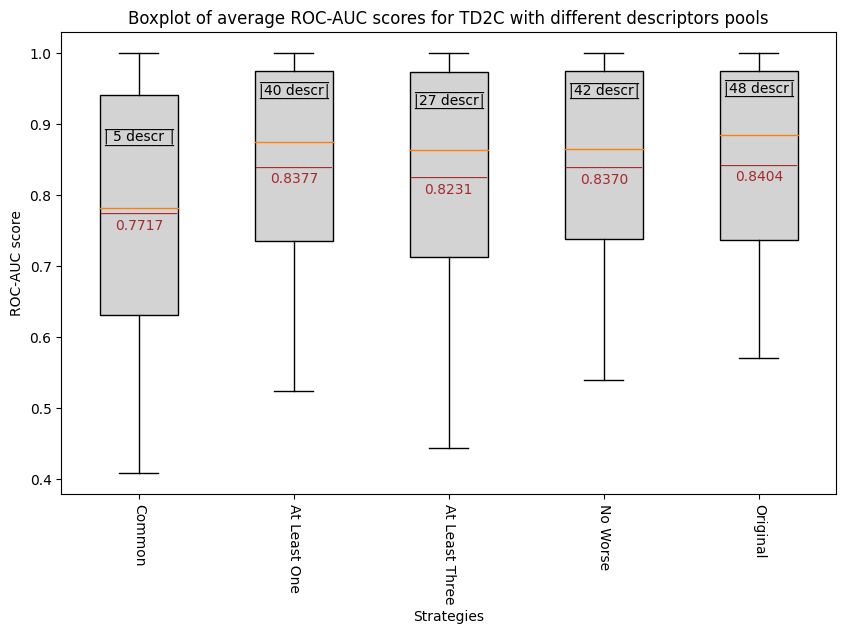

In [175]:
# dataframe with average values
df1 = pd.DataFrame(TD2C_roc_Common)
df2 = pd.DataFrame(TD2C_roc_AtLeastOne)
df3 = pd.DataFrame(TD2C_roc_AtLeastThree)
df4 = pd.DataFrame(TD2C_roc_original)
# df5 = pd.DataFrame(TD2C_roc_nb)
df6 = pd.DataFrame(TD2C_roc_nw)

# average values for
df1 = df1.mean()
df2 = df2.mean()
df3 = df3.mean()
df4 = df4.mean()
# df5 = df5.mean()
df6 = df6.mean()

# create a dataframe with the average values
df = pd.DataFrame({'Common': df1, 'At Least One': df2, 'At Least Three': df3, 'No Worse': df6, 'Original': df4}) # , 'No Best': df5
lengths = [len(common_vars)-8, len(union_vars)-8, len(common_3_vars)-8, len(no_worse_vars)-8, len(descriptorsss.columns)-8]

labels = df.columns

# boxplot of the dataframe
plt.figure(figsize=(10, 6))
# Set boxplot color to black
plt.boxplot(df, patch_artist=True, boxprops=dict(facecolor='lightgrey'))
# df.boxplot(color=dict(boxes='black', whiskers='black', medians='black', caps='black'))
plt.title('Boxplot of average ROC-AUC scores for TD2C with different descriptors pools')
# low label as "Strategies"
plt.xlabel('Strategies')
# label for each box
plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
# show mean values in the boxes
for i, value in enumerate(df.mean()):
    plt.text(i+1, value-0.025, f'{value:.4f}', ha='center', va='bottom', color='brown')
    plt.text(i+1, value, '___________', ha='center', va='bottom', color='brown')
    if i < len(lengths):
        plt.text(i+1, value+0.1, f'{lengths[i]} descr', ha='center', va='bottom', color='black')
        plt.text(i+1, value+0.097, '__________', ha='center', va='bottom', color='black')
        plt.text(i+1, value+0.1, '|              |', ha='center', va='bottom', color='black')
        plt.text(i+1, value+0.119, '__________', ha='center', va='bottom', color='black')


plt.ylabel('ROC-AUC score')
plt.show()



In [129]:
mean1 = df1.mean(axis=0).mean()
mean2 = df2.mean(axis=0).mean()
mean3 = df3.mean(axis=0).mean()
mean4 = df4.mean(axis=0).mean()
# mean5 = df5.mean(axis=0).mean()
mean6 = df6.mean(axis=0).mean()

# Create a DataFrame with the mean values
mean_df = pd.DataFrame({'Avg ROC-AUC score': [mean1, mean2, mean3, mean6, mean4]}, index=['Common', 'AtLeastOne', 'AtLeastThree', 'NoWorse', 'Original']) #, 'NoBest', # , mean5

# add a column with the number of variables considered by each method
mean_df['Involved Descriptors'] = [len(common_vars)-8, len(union_vars)-8, len(common_3_vars)-8, len(no_worse_vars)-8, len(descriptorsss.columns)-8] # , len(no_best_vars)-8

# sort the DataFrame
mean_df = mean_df.sort_values(by='Avg ROC-AUC score', ascending=False)

# add a name to the index = Selection Strategy
mean_df.index.name = 'Selection Strategy'

mean_df

,Avg ROC-AUC score,Involved Descriptors
Selection Strategy,,
Original,0.840440,48
AtLeastOne,0.837671,40
NoWorse,0.837044,42
AtLeastThree,0.823056,27
Common,0.771685,5


In [176]:
common_vars[8:]

# The variables in common variables selection are: I(m, cause), I(m,effect), I(m,cause|effect), I(m,effect|cause), First quantile of Conditional Mutual Information Descriptors. 

['cau_m_eff_q0', 'm_eff_q0', 'eff_m_cau_q0', 'com_cau', 'm_cau_q0']

# Classifier Selection

## Classification

#### Run Classifier

In [78]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_rocs_process = {}
    d2c_precision_process = {}
    d2c_recall_process = {}
    d2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_rocs_process[gen_process_number] = rocs
        d2c_precision_process[gen_process_number] = precisions
        d2c_recall_process[gen_process_number] = recalls
        d2c_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    D2C_rocs_process, D2C_precision_process, D2C_recall_process, D2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(D2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

# Final Comparisons